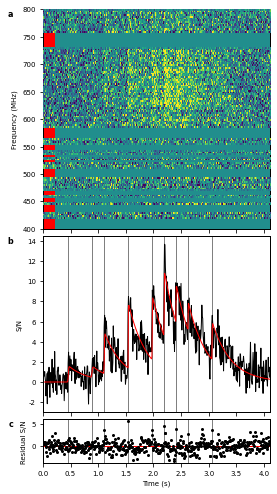

In [25]:
%matplotlib inline

# Figure 1

import matplotlib.pyplot as plt
from scipy.special import erfc
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701


# Figure
fig, ax = plt.subplots(
    3, 
    1, 
    figsize=(89 * mm_to_in, 89 * mm_to_in * 2),
    gridspec_kw={
        "height_ratios": [1, 0.8, 0.2], 
        "hspace": 0.05,
    },
    sharex=True
)

# Define functions
def exponorm(x,lam,mu,sigma):
    I = lam/2*np.exp(lam/2*(2*mu + lam*sigma**2 - 2*x))
    II = erfc((mu + lam*sigma**2 - x)/(2**0.5 * sigma))
    return I * II

def sum_emg(x,*args):
    #args are a1,mu1,sigma1, a2, mu2, sigma2, etc.
    if type(args) != list:
        args = np.array(args).flatten()
        args = list(args)
    scat = args.pop(-1)
    args = np.array(args).flatten()
    num_g = int(len(args)/3)
    args = args.reshape((num_g,3))
    a,mu,sigma = args[...,0], args[...,1], args[...,2]
    gaussian = np.zeros(len(x))
    for i in range(num_g):
        gaussian += a[i]*exponorm(x,scat, mu[i] ,sigma[i])
    return gaussian

def get_fit_results(f):
    chains = np.load(f)
    final_pars = np.zeros(chains.shape[-1])
    for i, chain in enumerate(chains.T):
        final_pars[i] = np.median(chain)
    return final_pars

# Load data
(
    intensity,
    profile,
    dt
) = np.load('data/65777546_plot_data.npz').values()
final_pars = get_fit_results('data/65777546_mcmc_chains.npy')
x = np.arange(100 // 8, intensity.shape[-1] + 100 // 8) * dt * 1000
model = np.sqrt(8) * sum_emg(x, final_pars)
peaks = np.resize(final_pars, (len(final_pars) // 3, 3))[:, 1] / 1000 - 100 // 8 * dt
# 100 bins have been removed from the profile for plotting purpuses
residuals = profile - model

# Plot parameters
vmin = np.nanpercentile(
    intensity,
    2.5
)
vmax = np.nanpercentile(
    intensity,
    100-2.5
)
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
xmax = intensity.shape[-1] * dt
rfi_xfrac = 0.05
t = np.arange(intensity.shape[-1]) * dt

# Plots
ax[0].imshow(
    intensity,
    origin="lower", 
    aspect="auto", 
    interpolation="nearest",
    extent=(0, xmax, 400, 800),
    vmin=vmin, 
    vmax=vmax, 
    cmap='viridis',
    zorder=3
)

ax[0].axvspan(
    0, 
    rfi_xfrac * xmax,
    color='r',
    zorder=2,
)
ax[0].axvspan(
    rfi_xfrac * xmax, 
    xmax, 
    color=cmap(norm(np.nanmedian(intensity))),
    zorder=1, 
)

ax[1].plot(t, profile, 'k', zorder=1)
ax[1].plot(t, model, 'r', zorder=2)

ax[2].plot(t, residuals, 'ko', ms=2, zorder=2)
ax[2].axhline(0, color='r', zorder=1)

for peak in peaks:
    ax[1].axvline(peak, color='grey', zorder=0)
    ax[2].axvline(peak, color='grey', zorder=0)
        
ax[0].set_ylabel("Frequency (MHz)")
ax[1].set_ylabel('S/N')
ax[2].set_ylabel('Residual S/N')
ax[2].set_xlabel("Time (s)")

for ax_i, letter in zip(ax, ['a', 'b', 'c']):
    ax_i.annotate(
        letter, 
        xy=(0, 1),
        xytext=(-30, 0),
        ha="right", va="top", 
        zorder=5, 
        color='k', 
        xycoords='axes fraction',
        textcoords='offset points',
        weight='bold',
        fontsize=8
    )
    
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig('plots/figure1.pdf', bbox_inches='tight', dpi=600)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars


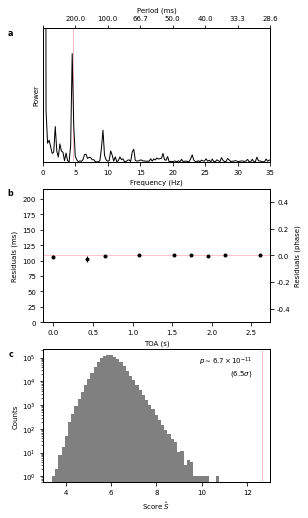

In [26]:
%matplotlib inline

# Figure 2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701


# FRB data
downsample = 8
dt = 0.00098304 * downsample

# Figure
fig, ax = plt.subplots(
    3, 
    1, 
    figsize=(89 * mm_to_in, 89 * mm_to_in * 2),
    gridspec_kw={
        "hspace": 0.2,
    }
)

# Load data
(
    ps,
    spin,
    toa,
    phase,
    phase_err,
    spin_period
) = np.load('data/65777546_timing.npz').values()
sims = np.load('data/sim_p9_g5_chi0.2.npy')

# Plots
ax[0].plot(spin * 1000, ps / ps.max(), 'k-')
ax[0].tick_params(left=False, labelleft=False)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_xlim(0, 35)
ax[0].set_ylim(0, 0.1)
ax[0].axvline(1 / spin_period * 1000, color='pink', zorder=-1)
fig.canvas.draw()
labels_in = [item.get_position()[0] for item in ax[0].get_xticklabels()]
labels_out = [f'{1e3/n:.1f}' for n in labels_in]
labels_out[0] = ''
ax0_t = ax[0].twiny()
ax0_t.set_xlim(ax[0].get_xlim())
ax0_t.set_xticks(ax[0].get_xticks())
ax0_t.set_xticklabels(labels_out)
ax0_t.set_xlabel('Period (ms)')

ax[1].errorbar(toa / 1000, phase + spin_period / 2, yerr=phase_err/2, fmt='k.')
ax[1].axhline(spin_period / 2, color='pink', zorder=-1)
ax[1].set_xlabel('TOA (s)')
ax[1].set_ylabel('Residuals (ms)')
ax[1].set_ylim(0, spin_period)
ax1_t = ax[1].twinx()
ax1_t.set_ylabel('Residuals (phase)')
ax1_t.set_ylim(-0.5,0.5)

ax[2].set_xlabel('Score $\hat S$')
ax[2].set_ylabel('Counts')
hist = ax[2].hist(sims, bins=np.linspace(0.0,14,100), log=True, color='grey')
vline = 12.64796
ax[2].axvline(vline, color='pink')
ax[2].annotate(
    r'$p\sim 6.7\times 10^{-11}$'+'\n'+r'$(6.5\sigma)$',
    xy = (vline, hist[0].max()),
    xytext=(-10, 0),
    zorder=5, 
    ha="right", va="top", 
    color='k', 
    textcoords='offset points'
)
ax[2].set_xlim(3, 13)

for ax_i, letter in zip(ax, ['a', 'b', 'c']):
    ax_i.annotate(
        letter, 
        xy=(0, 1),
        xytext=(-30, 0),
        ha="right", va="top", 
        zorder=5, 
        color='k', 
        xycoords='axes fraction',
        textcoords='offset points',
        weight='bold',
        fontsize=8
    )


fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig('plots/figure2.pdf', bbox_inches='tight', dpi=600)

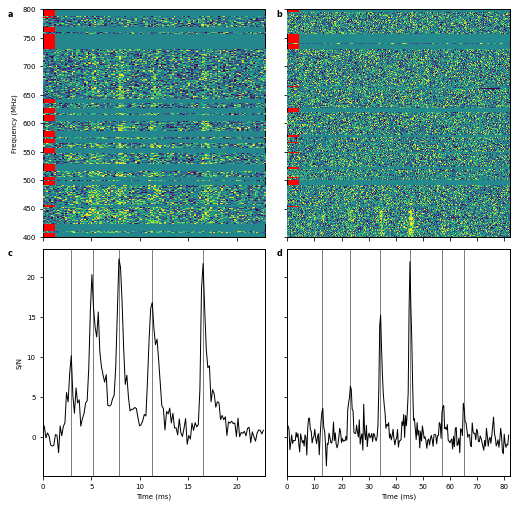

In [27]:
# ED Figure 1

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# Figure
fig, ax_arr = plt.subplots(
    2, 
    2, 
    figsize=(183 * mm_to_in, 183 * mm_to_in),
    gridspec_kw={
        "height_ratios": [1, 1], 
        "hspace": 0.05,
        "wspace": 0.1
    },
    sharex='col',
    sharey='row'
)

files_in = [
    'data/156410110_plot_data.npz',
    'data/157646917_plot_data.npz'
]

def get_profile(power):
    """Compute burst profile."""
    prof = np.nansum(power, axis=0) / np.sqrt(
        np.count_nonzero(~np.isnan(np.nansum(power, axis=-1)))
    )
    prof[prof == np.inf] = np.nan
    return prof

for f, ax in zip(files_in, ax_arr.T):
    # Load data
    intensity, profile, toa, dt = np.load(f).values()
    
    # Plot parameters
    vmin = np.nanpercentile(
        intensity,
        2.5
    )
    vmax = np.nanpercentile(
        intensity,
        100-2.5
    )
    cmap = matplotlib.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    xmax = intensity.shape[-1] * dt
    rfi_xfrac = 0.05
    t = np.arange(intensity.shape[-1]) * dt

    # Plots
    ax[0].imshow(
        intensity,
        origin="upper", 
        aspect="auto", 
        interpolation="nearest",
        extent=(0, xmax, 400, 800),
        vmin=vmin, 
        vmax=vmax, 
        cmap='viridis',
        zorder=3
    )

    ax[0].axvspan(
        0, 
        rfi_xfrac * xmax,
        color='r',
        zorder=2,
    )
    ax[0].axvspan(
        rfi_xfrac * xmax, 
        xmax, 
        color=cmap(norm(np.nanmedian(intensity))),
        zorder=1, 
    )

    ax[1].plot(t, profile, 'k', zorder=1)
    for t in toa:
        ax[1].axvline(t, color='grey', zorder=-1)

ax_arr[0, 0].set_ylabel("Frequency (MHz)")
ax_arr[1, 0].set_ylabel('S/N')
ax_arr[1, 0].set_xlabel('Time (ms)')
ax_arr[1, 1].set_xlabel('Time (ms)')

for ax_i, letter in zip(ax_arr.flatten(), ['a', 'b', 'c', 'd']):
    if letter in ['b', 'd']: pad = -5
    else: pad = -30
    ax_i.annotate(
        letter, 
        xy=(0, 1),
        xytext=(pad, 0),
        ha="right", va="top", 
        zorder=5, 
        color='k', 
        xycoords='axes fraction',
        textcoords='offset points',
        weight='bold',
        fontsize=8
    )
    
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig('plots/ED_figure1.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


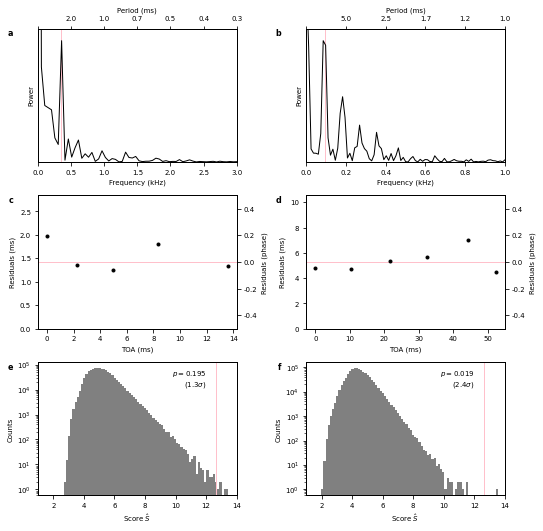

In [29]:
# ED Figure 2

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# FRB data
downsample = 8
dt = 2.56e-6 * downsample

# Figure
fig, ax_arr = plt.subplots(
    3, 
    2, 
    figsize=(183 * mm_to_in, 183 * mm_to_in),
    gridspec_kw={
        "hspace": 0.25,
        "wspace": 0.35
    },
    #sharex='col',
    #sharey='row'
)

files_in = [
    'data/156410110_timing.npz',
    'data/157646917_timing.npz'
]
file_sims = [
    'data/sim_p5_g2_chi0.2.npy',
    'data/sim_p6_g1_chi0.2.npy'
]

for f, f_sims, ax in zip(files_in, file_sims, ax_arr.T):
    # Load data
    (
        ps,
        spin,
        toa,
        phase,
        phase_err,
        spin_period
    ) = np.load(f).values()
    sims = np.load(f_sims)

    
    # Plots
    # Source parameters
    if f.endswith('156410110_timing.npz'):
        ax[0].set_xlim(0, 3)
        prob = r'$p = 0.195$' + '\n' + '$(1.3\sigma)$'
    else:
        ax[0].set_xlim(0, 1)
        prob = r'$p = 0.019$' + '\n' + '$(2.4\sigma)$'
        
    ax[0].plot(spin, ps / ps[ps.size//2:].max(), 'k-')
    ax[0].tick_params(left=False, labelleft=False)
    ax[0].set_xlabel('Frequency (kHz)')
    ax[0].set_ylabel('Power')
    ax[0].set_ylim(0, 1.1)
    ax[0].axvline(1 / spin_period, color='pink', zorder=-1)
    fig.canvas.draw()
    labels_in = [item.get_position()[0] for item in ax[0].get_xticklabels()]
    labels_out = [f'{1/n:.1f}' for n in labels_in]
    labels_out[0] = ''
    ax0_t = ax[0].twiny()
    ax0_t.set_xlim(ax[0].get_xlim())
    ax0_t.set_xticks(ax[0].get_xticks())
    ax0_t.set_xticklabels(labels_out)
    ax0_t.set_xlabel('Period (ms)')

    ax[1].errorbar(toa, phase + spin_period / 2, yerr=phase_err/2, fmt='k.')
    ax[1].axhline(spin_period / 2, color='pink', zorder=-1)
    ax[1].set_xlabel('TOA (ms)')
    ax[1].set_ylabel('Residuals (ms)')
    ax[1].set_ylim(0, spin_period)
    ax1_t = ax[1].twinx()
    ax1_t.set_ylabel('Residuals (phase)')
    ax1_t.set_ylim(-0.5,0.5)

    ax[2].set_xlabel('Score $\hat S$')
    ax[2].set_ylabel('Counts')
    hist = ax[2].hist(sims, bins=np.linspace(0.0,14,100), log=True, color='grey')
    vline = 12.64796
    ax[2].axvline(vline, color='pink')
    ax[2].annotate(
        prob,
        xy = (vline, hist[0].max()),
        xytext=(-10, 0),
        zorder=5, 
        ha="right", va="top", 
        color='k', 
        textcoords='offset points'
    )
    ax[2].set_xlim(1, 14)
    
for ax_i, letter in zip(ax_arr.flatten(), ['a', 'b', 'c', 'd', 'e', 'f']):
    ax_i.annotate(
        letter, 
        xy=(0, 1),
        xytext=(-25, 0),
        ha="right", va="top", 
        zorder=5, 
        color='k', 
        xycoords='axes fraction',
        textcoords='offset points',
        weight='bold',
        fontsize=8
    )
    
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig('plots/ED_figure2.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})

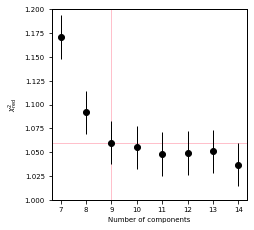

In [37]:
%matplotlib inline

# ED Figure 3

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# Figure
fig, ax = plt.subplots(
    figsize=(89 * mm_to_in, 89 * mm_to_in),
)


# Load data
(
    chi,
    npeaks,
    nbins
) = np.load('data/chi2red.npz').values()


# Calculations
dof = nbins - (3 * npeaks + 1)
chi_err = np.sqrt(2 / dof)
chi_err2 = np.sqrt(2 / nbins)


# Plots
ax.errorbar(npeaks, chi, yerr=chi_err, fmt='ko')
ax.axvline(9, color='pink', zorder=0)
ax.axhline(chi[2], color='pink', zorder=0)

ax.set_ylabel('$\chi^2_\mathrm{red}$')
ax.set_xlabel('Number of components')
ax.set_ylim(1,1.2)

plt.savefig('plots/ED_figure3.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})

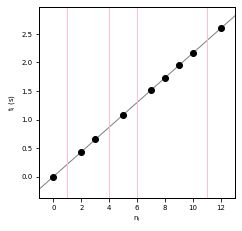

In [31]:
%matplotlib inline

# ED Figure 4

import matplotlib.pyplot as plt
from scipy.special import erfc
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# Figure
fig, ax = plt.subplots(
    figsize=(89 * mm_to_in, 89 * mm_to_in),
)

# Load data
(
    _,
    _,
    toa,
    _,
    _,
    spin_period
) = np.load('data/65777546_timing.npz').values()
toa /= 1000
spin_period /= 1000

# Calculations
n = toa / spin_period
n_int = np.round(n).astype(int)

n_all = np.arange(13)
gaps = np.setdiff1d(n_all, n_int)

x = np.array([-1, 13])
y = x * spin_period

# Plots
ax.plot(n, toa, 'ko', zorder=5)
ax.plot(x, y, 'grey', zorder=1)

for gap in gaps:
    ax.axvline(gap, color='pink')

ax.set_xlim(-1, 13)
ax.set_xlabel('$\mathregular{n_i}$')
ax.set_ylabel('$\mathregular{t_i}$ (s)')

fig.savefig('plots/ED_figure4.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})

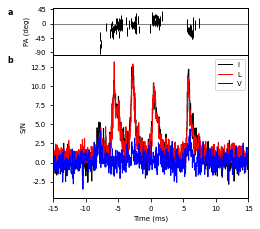

In [35]:
%matplotlib inline

# ED Figure 5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# Figure
fig, ax = plt.subplots(
    2, 
    1, 
    figsize=(89 * mm_to_in, 89 * mm_to_in),
    gridspec_kw={
        "height_ratios": [1, 3], 
        "hspace": 0,
    },
    sharex=True
)

# Load data
time, snr_I, snr_L, snr_V, PA, PA_err, PA_mask = np.load('data/156410110_polarisation_profile.npy')

# Plots
PA_mask = snr_L > 3.5
ax[0].errorbar(
    time[PA_mask],
    PA[PA_mask],
    yerr=PA_err[PA_mask],
    fmt="k.",
    ms=0,
    zorder=5
)
ax[0].axhline(0, color="grey")
ax[0].set_ylabel("PA (deg)")
ax[0].set_yticks(np.array([-90, -45, 0, 45, 90]))
ax[0].set_ylim([-100,50])
ax[1].step(time, snr_I, "k", label="I")
ax[1].step(time, snr_L, "r", label="L")
ax[1].step(time, snr_V, "b", label="V")
ax[1].set_ylabel("S/N")
ax[1].set_xlabel("Time (ms)")
ax[1].legend()
ax[1].set_xlim([-15,15])

for ax_i, letter in zip(ax.flatten(), ['a', 'b']):
    ax_i.annotate(
        letter, 
        xy=(0, 1),
        xytext=(-40, 0),
        ha="right", va="top", 
        zorder=5, 
        color='k', 
        xycoords='axes fraction',
        textcoords='offset points',
        weight='bold',
        fontsize=8
    )

fig.savefig('plots/ED_figure5.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:117: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.


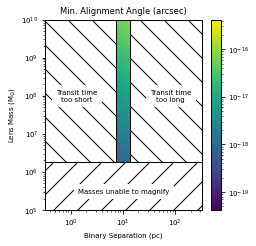

In [33]:
%matplotlib inline

# ED Figure 6

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Rectangle
from astropy import units
import matplotlib.colors as colors
from astropy.cosmology import Planck15 as cosmo
from astropy import constants
from astropy.cosmology import z_at_value

# Nature formatting
matplotlib.rcParams["font.size"] = 7
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Helvetica"
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams["axes.linewidth"] = 1
matplotlib.rcParams["ps.useafm"] = True
matplotlib.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams['axes.unicode_minus'] = False
mm_to_in = 0.0393701

# Figure
fig, ax1 = plt.subplots(
    figsize=(89 * mm_to_in, 89 * mm_to_in),
)

# Calculations
M = np.logspace(5,10,100) # 20 Msun (log scapce from 1e0 to 1e2)
R = np.logspace(13,16,100) # 35km
R1 = R * 3.24078E-14
M_lens = M[:,None] * constants.M_sun # mass of lens
M_source = 1.4 * constants.M_sun
D_ls = R[None,:] * units.km # separation of the Hulse–Taylor binary 
ms_peak_flux_Jy = 1.
crab_lum_Jy = 2.2 #Jy kpc^2
z_source = 0.3 # DM is about 300 --> z=0.3
D_l = cosmo.angular_diameter_distance(z_source)
D_s = D_l.to(units.km) + D_ls.to(units.km) # distance to source
crossing_time_ms_min = 100.
crossing_time_ms_max = 200.
S_to_N = 15.

R_Schwartzchild = 2 * constants.G * M_lens.to(units.kg) / constants.c**2
theta_E = units.radian*(2 * R_Schwartzchild.to(units.km) * D_ls.to(units.km) / D_s.to(units.km) / D_l.to(units.km))**0.5 # einstein angle

crab_apparent_brightness_Jy = crab_lum_Jy *((3262*units.lyr).to(units.km))**2 / ( D_l.to(units.km) )**2 # luminosity
peak_magnification = np.round(ms_peak_flux_Jy / crab_apparent_brightness_Jy)
approx_beta = 2 * (1 / (1 - 2 / peak_magnification)**0.25 - 1) * theta_E
a_ = ((approx_beta).to(units.arcsec)).value

def approx_beta_from_magnification( magnification, theta_E ):
    mu = magnification /2.
    epsilon = 1./(1.-1./mu)**0.25 - 1.
    return 2* epsilon * theta_E
def time_for_one_Xth_magnification( orig_magnification, theta_E, average_v, D_l ,mag_ratio=10):
    beta_max_mag = approx_beta_from_magnification( orig_magnification, theta_E )
    beta_one_tenth_mag = approx_beta_from_magnification( orig_magnification/mag_ratio, theta_E )
    offset_max_mag = np.tan(beta_max_mag) * D_l.to(units.km)
    offset_one_tenth_mag = np.tan(beta_one_tenth_mag) * D_l.to(units.km)
    return ( ( offset_max_mag - offset_one_tenth_mag ) / average_v.to(units.km/units.s) ).to(units.s)
period = ( D_ls.to(units.m)**3 * 4 * np.pi**2 / (constants.G * (M_source + M_lens)) )**0.5
v1 = ( ( 2 * np.pi * constants.G / period ) * M_lens**3 / (M_source+M_lens)**2 )**(1./3)
v2 = v1 * M_source/M_lens
time_oneXth_ms = 1000. * np.abs(
    time_for_one_Xth_magnification(
        peak_magnification,
        theta_E, 
        (v1+v2)/2., 
        D_l, 
        mag_ratio = S_to_N 
    ).to(units.s).value
)
y = approx_beta / theta_E
z_l = z_at_value( cosmo.angular_diameter_distance, D_l, zmax=3.)  
time_delay_s = ( 4 * constants.G * M_lens.to(units.kg) / constants.c**3 ) * (1+z_l) * (
             y/2 * np.sqrt(y**2+4) + np.log( (np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y) ) )
approx_mag = (y**2 +2) / (y * np.sqrt(y**2 + 4)) 

mask = ( 
    (time_oneXth_ms < crossing_time_ms_min)  
    | (time_oneXth_ms > crossing_time_ms_max)
    | (time_delay_s.value > 2.56E-6) 
    | ((8*np.pi**2 * constants.G* (M_lens*np.ones(D_ls.shape)) *600e6*units.Hz/ constants.c**3 ) < peak_magnification/S_to_N) 
    | (8*np.pi**2 * constants.G* (M_lens*np.ones(D_ls.shape)) *600e6*units.Hz/ constants.c**3  < approx_mag ) 
)
zeroed_indices = np.where(mask)
zeroed_y = a_.copy()
zeroed_y[ zeroed_indices ] = np.nan
mask = np.where(~np.isnan(zeroed_y))
maskx_,masky_ = mask[0],mask[1]
maskx_min,maskx_max = np.amin(maskx_),np.amax(maskx_)
masky_min,masky_max = np.amin(masky_),np.amax(masky_)


# Plots
my2plot = ax1.pcolormesh(
    R1, 
    M, 
    a_,
    norm = colors.LogNorm(vmin=np.amin(a_), vmax=np.amax(a_)),
    cmap ='viridis'
)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Binary Separation (pc)')
ax1.set_ylabel('Lens Mass (M$_{\odot}$)')
ax1.set_title("Min. Alignment Angle (arcsec)")

my2colorbar = plt.colorbar(my2plot, orientation='vertical')

ax1.add_patch(Rectangle((0, 0), R1[masky_min],  M[maskx_max] ,facecolor='w', hatch='\ ' ,edgecolor='black', alpha=1))
ax1.add_patch(Rectangle((R1[masky_max], 0), R1[-1],  M[maskx_max] ,facecolor='w', hatch='\ ', edgecolor='black', alpha=1))
ax1.add_patch(Rectangle((0, 0), R1[-1],  M[maskx_min] ,facecolor='w', edgecolor='black', hatch='/',alpha=1))

ax1.annotate(
    'Transit time\ntoo short', 
    xy = (0.2, 0.6),  
    backgroundcolor='w',
    xycoords='axes fraction',
    ha='center',
    va='center'
)
ax1.annotate(
    'Transit time\ntoo long', 
    xy = (0.8, 0.6),  
    backgroundcolor='w',
    xycoords='axes fraction',
    ha='center',
    va='center'
)
ax1.annotate(
    r'Masses unable to magnify', 
    xy = (0.5, 0.1),  
    backgroundcolor='w',
    xycoords='axes fraction',
    ha='center',
    va='center'
)


fig.savefig('plots/ED_figure6.jpg', bbox_inches='tight', dpi=300, pil_kwargs={'quality': 95})